Includes:

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sn
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from data_paths import get_file_paths_ordered
from tf_lite_conversion import convert_to_tf_lite, eval_tf_lite_model
from scipy.io import wavfile
from IPython.display import Audio
from pre_process import choose_tot_slice_len, get_data_tensors, compute_mfccs
from models import get_model

Number of speakers and the percentage of the available samples to use to consider:

In [2]:
# Number of speakers and the percentage of the available samples to use to consider:
num_speakers = 25
model_name = 'test_' + str(num_speakers) + '_spk'
dataset_percentage = 1. # 0.85
segmentLength=1024
print("Number of speakers : ", num_speakers)

Number of speakers :  25


Save Locations

In [3]:

model_dir_root = './Models/'+ f'{model_name}/'

path_keras_model = model_dir_root + 'KerasModels/'
path_tf_lite_nq = model_dir_root + 'TFLiteModelsNonQuantized/'
path_tf_lite_q = model_dir_root + 'TFLiteModelsQuantized/'
path_figures = model_dir_root + 'Figures/'
path_quant_test_set = model_dir_root + 'TestSetQuantized/'

# Create the directories
paths = [path_keras_model, path_tf_lite_nq, path_tf_lite_q, path_figures, path_quant_test_set]

for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

print('Models will be saved to: ', model_dir_root)

model_name_keras = 'keras_'+ model_name + '.h5'
model_name_tf_lite_nq = 'tflite_nq_'+ model_name + '.tflite'
model_name_tf_lite_q = 'tflite_q_'+ model_name + '.tflite'

Models will be saved to:  ./Models/test_25_spk/


Read data:

Total number of speakers in the original dataset: 25
Number of speakers that will be used for training:25 => 100.0%
Original number of files:  10826
Training number of files : 8660 => 79.9926103824127%


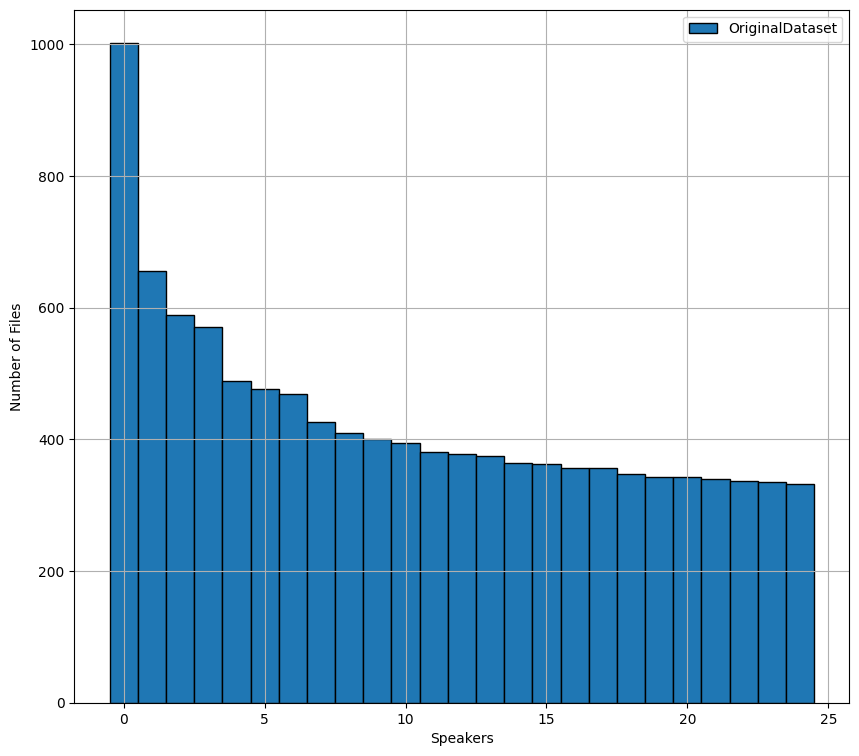

Visualization of the samples ...


100%|██████████| 10826/10826 [00:56<00:00, 191.82it/s] 


In [4]:
paths_train, paths_test, y_train_l, y_test_l, all_paths_l = \
    get_file_paths_ordered(num_speaker=num_speakers, test_ratio=0.2, balanced_dataset=False, 
                           path_plot_sv=path_figures)

slice_len, durations = choose_tot_slice_len(paths=all_paths_l)


C:\Users\kerem\AppData\Local\Temp\ipykernel_24760\2069709077.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(path_figures + 'slice_len_sel.png')
c:\Users\kerem\anaconda3\envs\ml_mcu_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


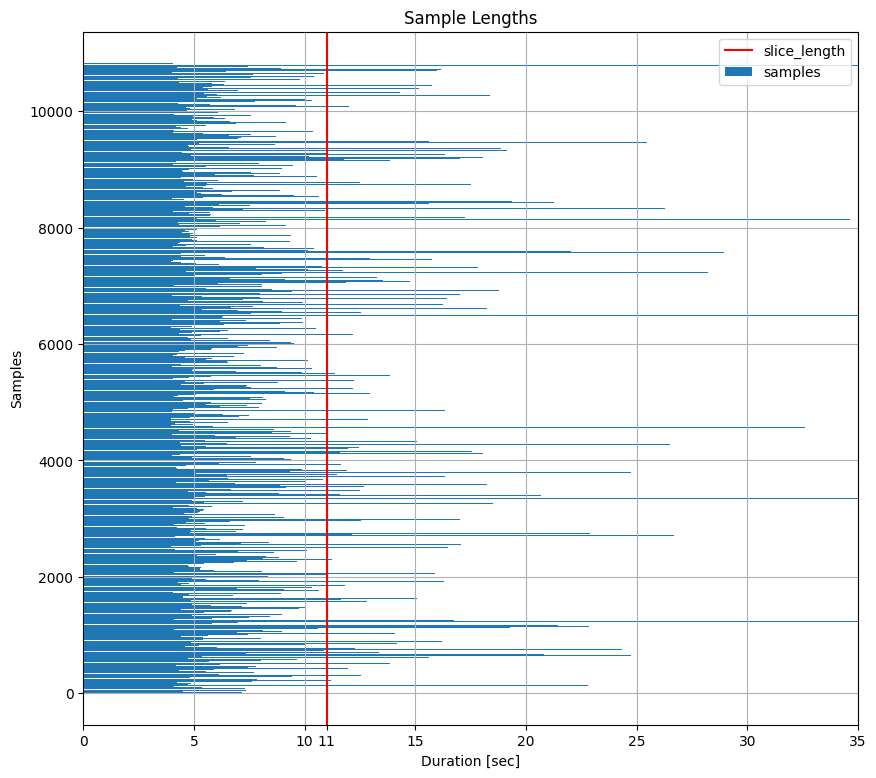

In [5]:
nb_samps = len(all_paths_l)
plt.figure(figsize=(10,9))
plt.title("Sample Lengths")
plt.xlabel("Duration [sec]")
plt.ylabel("Samples")
plt.barh(np.arange(0, nb_samps, 1), durations, height=0.9, label='samples')
plt.grid()
plt.axvline(x=slice_len, ymin=0, ymax=nb_samps, color='r', label='slice_length')
plt.xlim((0, 35))
plt.xticks(np.append(plt.xticks()[0], slice_len))
plt.legend()
plt.savefig(path_figures + 'slice_len_sel.png')
plt.show()

In [6]:
with tf.device("/cpu:0"):
    f_s, x_train, y_train, x_test, y_test = get_data_tensors(paths_train=paths_train, paths_test=paths_test, 
                                                            y_train_l=y_train_l, y_test_l=y_test_l,
                                                            tot_slice_len=slice_len,
                                                            used_train_sz_rat=dataset_percentage, 
                                                            used_test_sz_rat=1.,
                                                            segmentLength=segmentLength)
print("Train - test size before feature extraction : ", x_train.shape, x_test.shape)

100%|██████████| 2166/2166 [00:03<00:00, 620.11it/s]


Train - test size before feature extraction :  (8660, 171, 1024) (2166, 171, 1024)


Play a random sample:

In [7]:
i=1
fs_i, audio_data_i = wavfile.read(paths_train[i])
display(Audio(audio_data_i, rate=fs_i))

Pre-Processing:

In [8]:
f_low=80.
f_up=7600.
num_mel_bins=80
num_mfcc=13

with tf.device("/cpu:0"):
    x_train_mfcc = compute_mfccs(x_train, frame_length=segmentLength, sample_rate=f_s, 
                                lower_edge_hertz=f_low, upper_edge_hertz=f_up,
                                num_mel_bins=num_mel_bins, num_mfcc=num_mfcc)
    x_test_mfcc  = compute_mfccs(x_test, frame_length=segmentLength, sample_rate=f_s, 
                                lower_edge_hertz=f_low, upper_edge_hertz=f_up,
                                num_mel_bins=num_mel_bins, num_mfcc=num_mfcc)

Plot an example MFCC

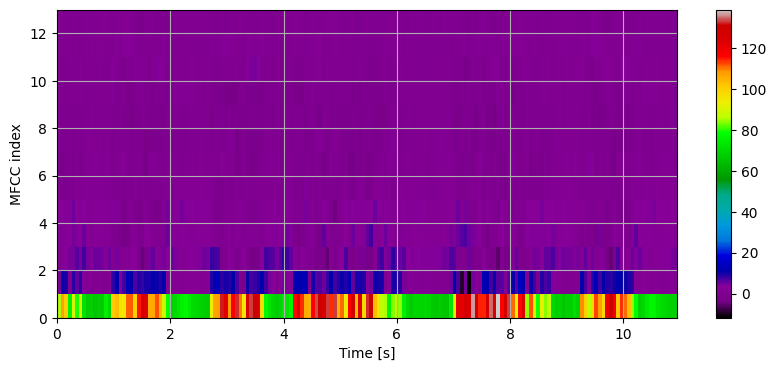

In [9]:
plt.figure(figsize=(10, 4))
extent = [0, x_train_mfcc[i].shape[0]*segmentLength/fs_i, 0, num_mfcc]
plt.imshow(tf.transpose(x_train_mfcc[i], [1, 0, 2]), interpolation="nearest", origin="lower", 
           aspect="auto", extent=extent, cmap='nipy_spectral')
plt.colorbar()
plt.xlabel("Time [s]")
plt.ylabel("MFCC index")
plt.grid()
plt.savefig(path_figures + 'mfcc_example.png')
plt.show()

# Keras Model:

In [10]:
train_set = x_train_mfcc
test_set = x_test_mfcc
print("Train - test size after feature extraction : ", train_set.shape, test_set.shape)
print("Labels shape: ", y_test.shape)

# save the test data as numpy arrays
np.save(path_quant_test_set+'x_test.npy', test_set.numpy())  #.astype(np.int8))

y_test_save = np.zeros((y_test.shape[0], 1, 1, num_speakers))
y_test_np = y_test.numpy()
for i in range(y_test.shape[0]):
    y_test_save[i, :, :, y_test_np[i]] = 1
print("Saved labels shape: ", y_test_save.shape)
np.save(path_quant_test_set+'y_test.npy', y_test_save)  #.astype(np.int8))

Train - test size after feature extraction :  (8660, 171, 13, 1) (2166, 171, 13, 1)
Labels shape:  (2166,)
Saved labels shape:  (2166, 1, 1, 25)


In [11]:
model_idx = 1
input_shape = train_set.shape
model = get_model(input_shape=input_shape, nb_classes=num_speakers, model_idx=model_idx)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (8660, 171, 13, 1)       3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (8660, 171, 13, 16)       160       
                                                                 
 batch_normalization (BatchN  (8660, 171, 13, 16)      64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (8660, 171, 13, 16)       0         
                                                                 
 conv2d_1 (Conv2D)           (8660, 86, 7, 32)         4640      
                                                                 
 batch_normalization_1 (Batc  (8660, 86, 7, 32)        1

Save the model summary:

In [12]:
from contextlib import redirect_stdout

with open(model_dir_root + 'keras_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

Visualize the model

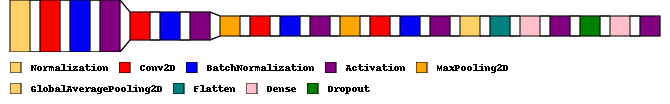

In [13]:
import visualkeras
from collections import defaultdict
from tensorflow.keras import layers

color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = 'red'
color_map[layers.MaxPooling2D]['fill'] = 'orange'
color_map[layers.Dense]['fill'] = 'pink'
color_map[layers.Flatten]['fill'] = 'teal'
color_map[layers.Dropout]['fill'] = 'green'
color_map[layers.BatchNormalization]['fill'] = 'blue'
color_map[layers.Activation]['fill'] = 'purple'


visualkeras.layered_view(model, legend=True, color_map=color_map, draw_volume=False)

Define learning parameters:

In [14]:
batchSize = 32 #8 # nb of togetherly processed segments(of 1024 samples each) 
epochs = 150 #40 # nb of back propagations
loss_fct = 'sparse_categorical_crossentropy'

Compile the model and Fit the Data:

In [15]:
model.compile(
    loss=loss_fct, 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(path_keras_model + model_name_keras, save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=15, min_lr=1.0e-5,verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, verbose=1),       
]

history_keras = model.fit(x=train_set, 
                          y=y_train, 
                          batch_size=batchSize, 
                          epochs=epochs, 
                          validation_split=0.2,
                          callbacks = callbacks)

Epoch 1/150
217/217 [==============================] - 17s 21ms/step - loss: 2.0453 - accuracy: 0.4288 - val_loss: 2.1494 - val_accuracy: 0.4203 - lr: 0.0010
Epoch 2/150
217/217 [==============================] - 3s 15ms/step - loss: 1.1309 - accuracy: 0.6656 - val_loss: 2.4063 - val_accuracy: 0.2921 - lr: 0.0010
Epoch 3/150
217/217 [==============================] - 3s 16ms/step - loss: 0.8664 - accuracy: 0.7400 - val_loss: 1.4646 - val_accuracy: 0.5722 - lr: 0.0010
Epoch 4/150
217/217 [==============================] - 3s 16ms/step - loss: 0.6978 - accuracy: 0.7947 - val_loss: 1.0636 - val_accuracy: 0.6570 - lr: 0.0010
Epoch 5/150
217/217 [==============================] - 3s 16ms/step - loss: 0.5954 - accuracy: 0.8171 - val_loss: 1.1909 - val_accuracy: 0.6282 - lr: 0.0010
Epoch 6/150
217/217 [==============================] - 3s 14ms/step - loss: 0.5130 - accuracy: 0.8427 - val_loss: 1.0248 - val_accuracy: 0.7032 - lr: 0.0010
Epoch 7/150
217/217 [==============================] - 3s

Evaluate the performance on the test set:

In [16]:
model = keras.models.load_model(path_keras_model + model_name_keras)
y_pred = model.predict(x_test_mfcc)

test_loss, test_acc = model.evaluate(x_test_mfcc,  y_test, verbose=2)
print('Test accuracy:', test_acc*100, '%')
print('Test loss:', test_loss)

68/68 [==============================] - 0s 2ms/step
68/68 - 0s - loss: 0.2547 - accuracy: 0.9428 - 221ms/epoch - 3ms/step
Test accuracy: 94.27515864372253 %
Test loss: 0.25469154119491577


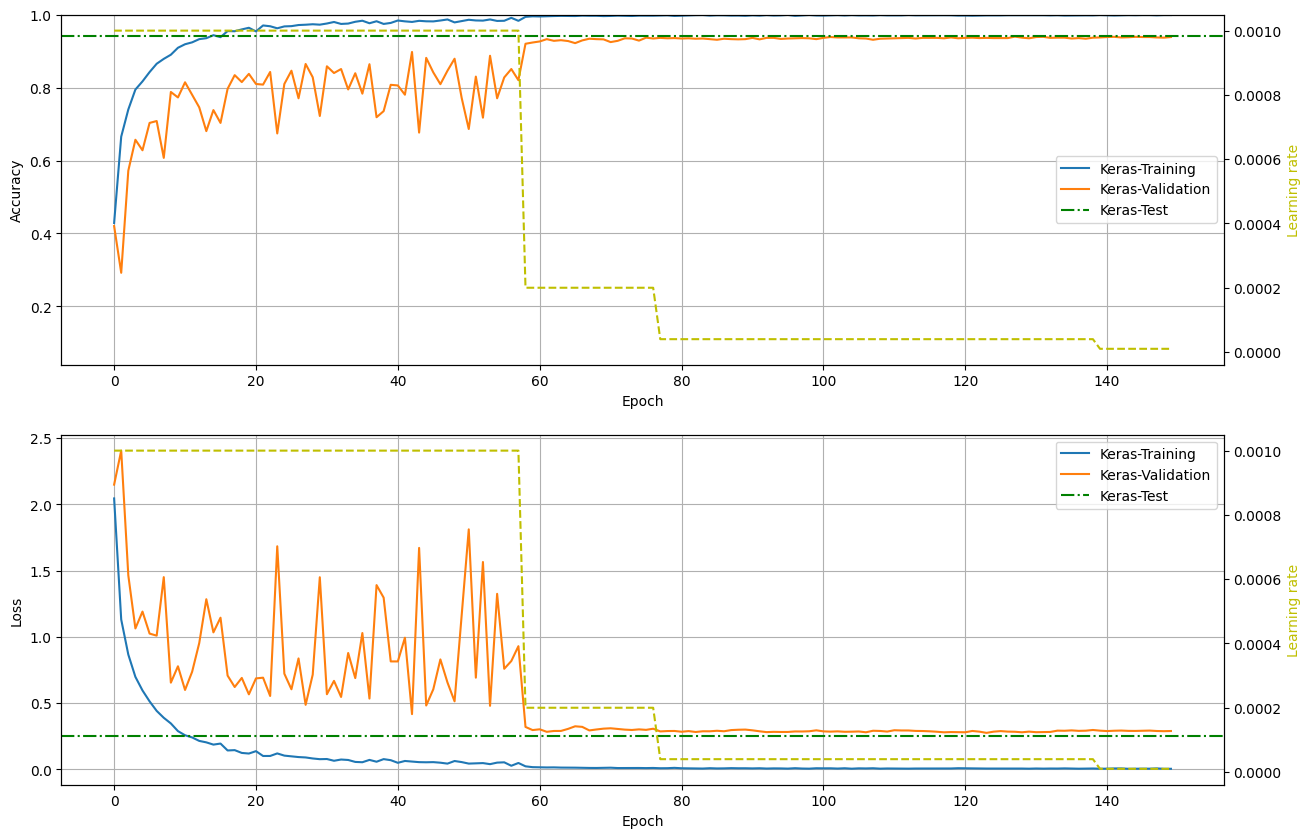

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

# Accuracy plot
ax2 = ax[0].twinx()
ax[0].plot(history_keras.history['accuracy'], label='Keras-Training')
ax[0].plot(history_keras.history['val_accuracy'], label='Keras-Validation')
ax[0].axhline(y=test_acc, xmin=0, xmax=epochs, linestyle='-.', color='g', label='Keras-Test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([1/num_speakers, 1])
ax2.plot(history_keras.history['lr'], color='y', linestyle='--')
ax2.set_ylabel('Learning rate', color='y')
ax[0].legend(loc='right')
ax[0].grid()

# Loss plot
ax3 = ax[1].twinx()
ax[1].plot(history_keras.history['loss'], label='Keras-Training')
ax[1].plot(history_keras.history['val_loss'], label='Keras-Validation')
ax[1].axhline(y=test_loss, xmin=0, xmax=epochs, linestyle='-.', color='g', label='Keras-Test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax3.plot(history_keras.history['lr'], color='y', linestyle='--')
ax3.set_ylabel('Learning rate', color='y')
ax[1].legend(loc='upper right')
ax[1].grid()


plt.savefig(path_figures + 'keras_acc_loss_epochs.png')
plt.show()

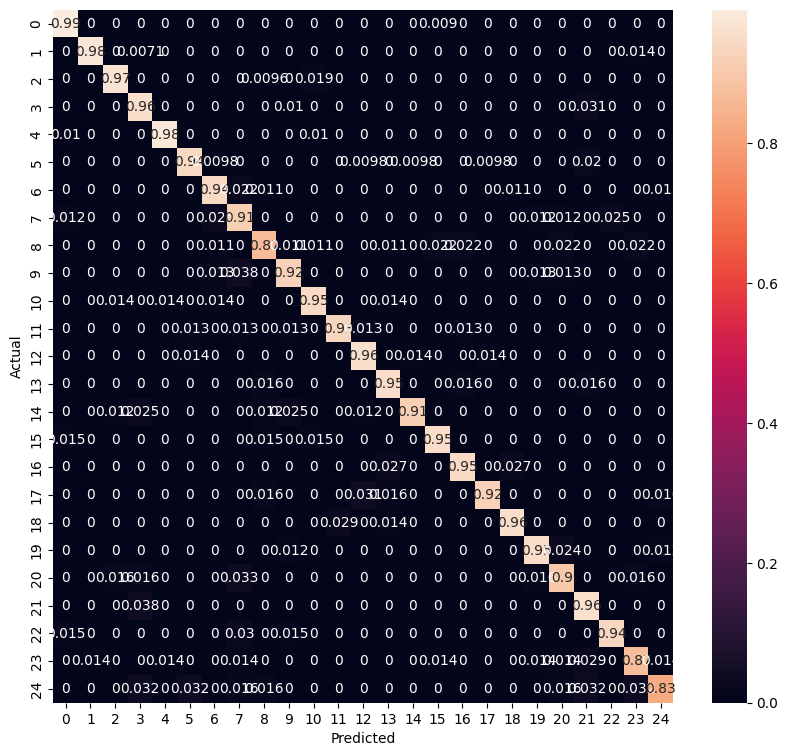

In [18]:
y_pred_hard = np.argmax(y_pred, axis=1)
fig = plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, y_pred_hard, normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(path_figures + 'keras_cm.png')
plt.show()

Information about the saved Kerras Model on disk:

In [19]:
h5_in_kb = os.path.getsize(path_keras_model+model_name_keras) / 1024
print("Keras model file : ", model_name_keras)
print("HDF5 Keras Model size: %d KB" % h5_in_kb)

Keras model file :  keras_test_25_spk.h5
HDF5 Keras Model size: 1309 KB


# TF Lite Conversion and Quantization:

In [40]:
tflite_nq, tflite_q, sizes_on_disk, comp_rats, legends = \
    convert_to_tf_lite(keras_model=model,
                       path_keras_model=path_keras_model + model_name_keras, 
                       path_tf_lite_nq_model=path_tf_lite_nq + model_name_tf_lite_nq,
                       train_set=train_set, 
                       path_tf_lite_q_model=path_tf_lite_q + model_name_tf_lite_q)

INFO:tensorflow:Assets written to: C:\Users\kerem\AppData\Local\Temp\tmp0szlism_\assets


INFO:tensorflow:Assets written to: C:\Users\kerem\AppData\Local\Temp\tmp0szlism_\assets


INFO:tensorflow:Assets written to: C:\Users\kerem\AppData\Local\Temp\tmppbe304e_\assets


INFO:tensorflow:Assets written to: C:\Users\kerem\AppData\Local\Temp\tmppbe304e_\assets
c:\Users\kerem\anaconda3\envs\ml_mcu_env\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


HDF5 Model size without quantization: 1309 KB
TFLite Model size without quantization: 404 KB

Reduction in model size from Keras to TFLite by a factor of 3.236908
Quantized TFLite Model size: 112 KB

Reduction in model size from Keras to TFLiteQuantized by a factor of 11.626414


Plot the disk size comparisons:

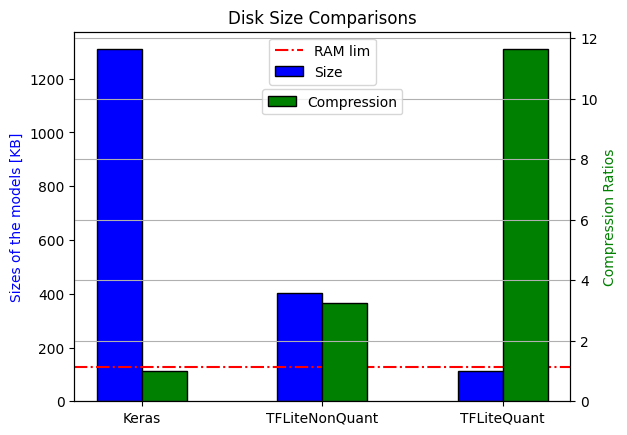

In [41]:
mcu_ram_lim = 128  # KB
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
width=0.25
x_ax_tmp = np.arange(len(legends))

ax1.bar(x_ax_tmp, sizes_on_disk, color='b', width=width, edgecolor='k', label='Size')
ax1.set_ylabel("Sizes of the models [KB]", color='b')
ax1.axhline(y=mcu_ram_lim, xmin=0., xmax=len(legends), linestyle='-.', color='r', label='RAM lim')
ax1.legend(loc='upper center')

ax2.bar(x_ax_tmp+width, comp_rats, color='g', width=width, edgecolor='k', label='Compression')
ax2.set_ylabel("Compression Ratios", color='g')
ax2.legend(loc='center', bbox_to_anchor=(0.52, 0.81))

plt.grid()
plt.title("Disk Size Comparisons")
plt.xticks(x_ax_tmp+width/2, legends)
plt.savefig(path_figures + 'size_comps.png')
plt.show()

# Performance evaluation Non-Quantized Model

In [42]:
pred_nq = eval_tf_lite_model(path_tf_lite_model=path_tf_lite_nq + model_name_tf_lite_nq,
                             test_set=test_set, 
                             quantized=False)

Evaluated model:  ./Models/test_25_spk/TFLiteModelsNonQuantized/tflite_nq_test_25_spk.tflite
Input shape is [  1 171  13   1] and of type <class 'numpy.float32'>
Output shape is [ 1 25] and of type <class 'numpy.float32'>


In [43]:
tflite_nq_score = accuracy_score(y_test, pred_nq)
print("Accuracy of non-quantized tflite model is {}%".format(tflite_nq_score*100))
print("Compared to float32 accuracy of {}%".format(test_acc*100))
print("We have a change of {}%".format((tflite_nq_score-test_acc)*100))

Accuracy of non-quantized tflite model is 94.27516158818098%
Compared to float32 accuracy of 94.27515864372253%
We have a change of 2.9444584437321453e-06%


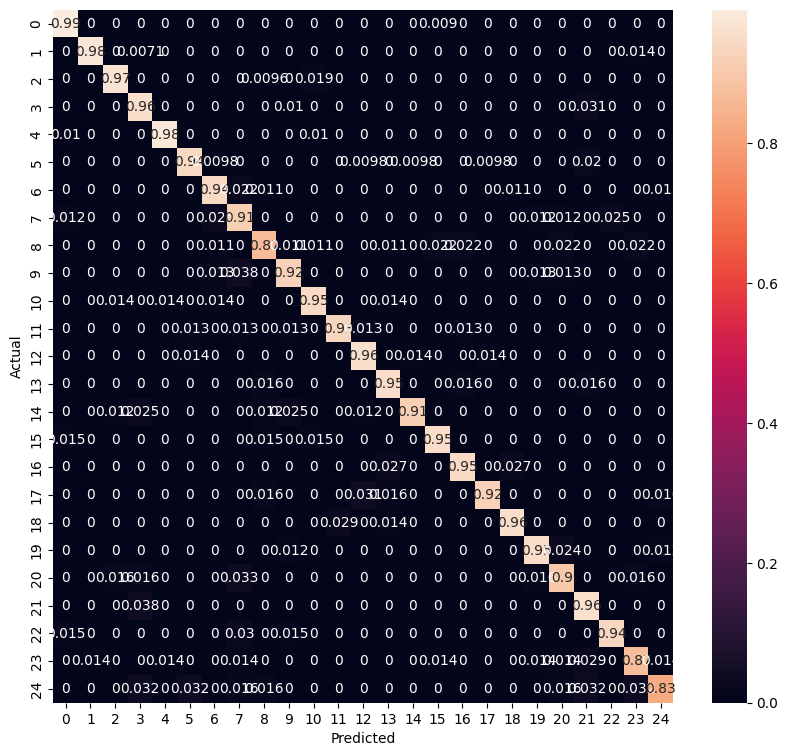

In [44]:
plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, pred_nq, 
                      normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(path_figures + 'tflite_nq_cm.png')
plt.show()

# Performance evaluation Quantized Model

In [50]:
pred_q = eval_tf_lite_model(path_tf_lite_model=path_tf_lite_q + model_name_tf_lite_q,
                            quantized=True, 
                            test_set=test_set)

Evaluated model:  ./Models/test_25_spk/TFLiteModelsQuantized/tflite_q_test_25_spk.tflite
Input shape is [  1 171  13   1] and of type <class 'numpy.int8'>
Output shape is [ 1 25] and of type <class 'numpy.int8'>


In [46]:
tflite_q_score = accuracy_score(y_test, pred_q)
print("Accuracy of quantized to int8 model is {}%".format(tflite_q_score*100))
print("Compared to float32 accuracy of {}%".format(test_acc*100))
print("We have a change of {}%".format((tflite_q_score-test_acc)*100))

Accuracy of quantized to int8 model is 64.31209602954755%
Compared to float32 accuracy of 94.27515864372253%
We have a change of -29.963062614174984%


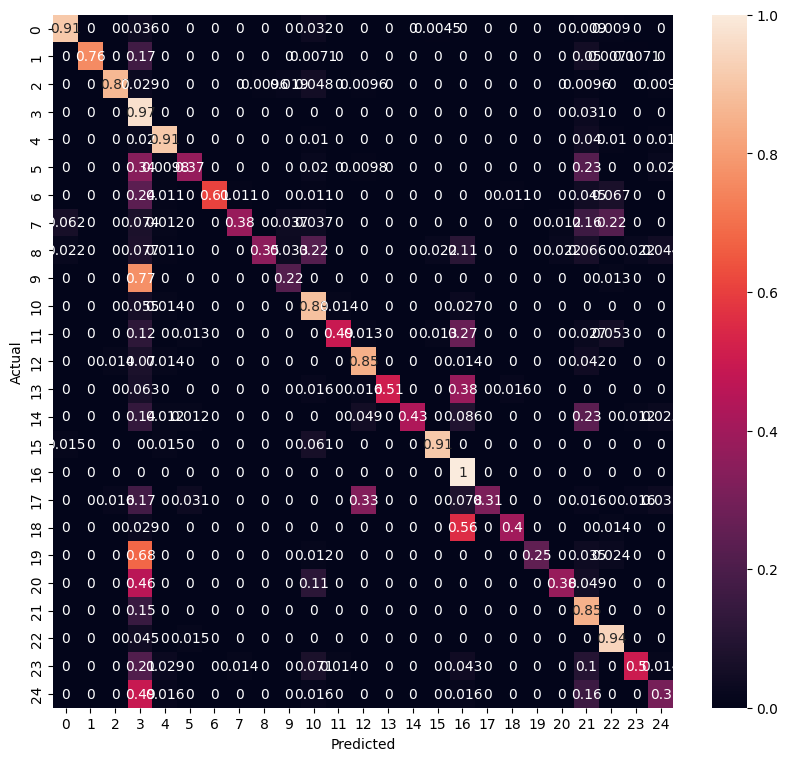

In [47]:
plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, pred_q, 
                      normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(path_figures + 'tflite_q_cm.png')
plt.show()

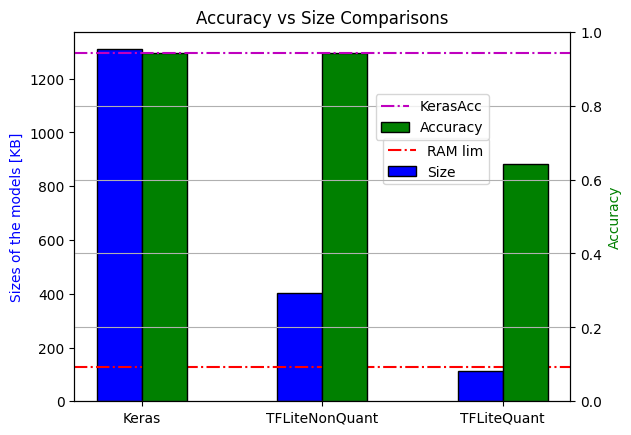

In [48]:
# Plots for comparison
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
width=0.25
x_ax_tmp = np.arange(len(legends))

ax1.bar(x_ax_tmp, sizes_on_disk, color='b', width=width, edgecolor='k', label='Size')
ax1.set_ylabel("Sizes of the models [KB]", color='b')
ax1.axhline(y=mcu_ram_lim, xmin=0., xmax=len(legends), linestyle='-.', color='r', label='RAM lim')
ax1.legend(loc='upper right',  bbox_to_anchor=(0.85, 0.73))

ax2.bar(x_ax_tmp+width, [test_acc, tflite_nq_score, tflite_q_score], 
        color='g', width=width, edgecolor='k', label='Accuracy')
ax2.set_ylabel("Accuracy", color='g')
ax2.set_ylim([0., 1.])
ax2.axhline(y=test_acc, xmin=0., xmax=1., linestyle='-.', color='m', label='KerasAcc')
ax2.legend(loc='upper right',  bbox_to_anchor=(0.85, 0.85))

plt.grid()
plt.title("Accuracy vs Size Comparisons")
plt.xticks(x_ax_tmp+width/2, legends)
plt.savefig(path_figures + 'acc_comps.png')
plt.show()